In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

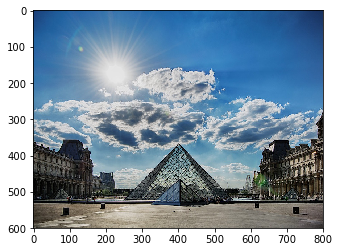

In [3]:
content_image = scipy.misc.imread("images/louvre.jpg")
imshow(content_image)

In [4]:
#content cost
def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = tf.convert_to_tensor(a_G).get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) 
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) 
    
    J_content = 1/(4 * n_H * n_W * n_C) * tf.reduce_sum( (a_C - a_G)**2 )
    
    return J_content

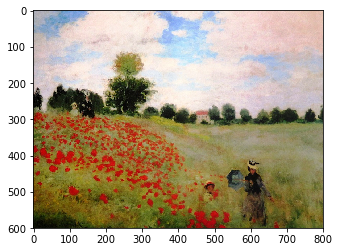

In [5]:
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image)

In [6]:
def gram_matrix(A):
    
    GA =tf.matmul( A, tf.transpose(A) )
    
    return GA

In [7]:
def compute_layer_style_cost(a_S, a_G):
    
    m, n_H, n_W, n_C = tf.convert_to_tensor(a_S).get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[n_H * n_W, n_C]) )
    a_G = tf.transpose(tf.reshape(a_G, shape=[n_H * n_W, n_C]) )  

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = 1/(4 * n_C**2 * (n_H * n_W)**2) * tf.reduce_sum( (GS - GG)**2 )
    
    return J_style_layer

In [8]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [9]:
#style cost
def compute_style_cost(model, STYLE_LAYERS):
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

In [10]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha * J_content + beta * J_style
    
    return J

In [11]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [12]:
content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

style_image = scipy.misc.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)

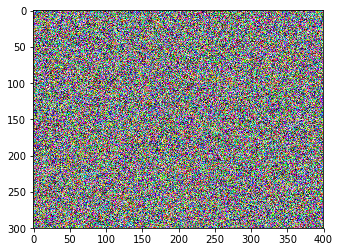

In [13]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [14]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [15]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)
a_G = out

J_content = compute_content_cost(a_C, a_G)

In [16]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [17]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [18]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [19]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
        
        sess.run(train_step)
        
        generated_image = sess.run(model["input"])
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("output/" + str(i) + ".png", generated_image)

    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [20]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5.07048e+09
content cost = 7911.52
style cost = 1.2676e+08
Iteration 20 :
total cost = 9.4214e+08
content cost = 15111.5
style cost = 2.35497e+07
Iteration 40 :
total cost = 4.77177e+08
content cost = 16589.7
style cost = 1.19253e+07
Iteration 60 :
total cost = 3.10442e+08
content cost = 17303.8
style cost = 7.75672e+06
Iteration 80 :
total cost = 2.29365e+08
content cost = 17655.2
style cost = 5.72972e+06
Iteration 100 :
total cost = 1.82878e+08
content cost = 17846.7
style cost = 4.56748e+06
Iteration 120 :
total cost = 1.52222e+08
content cost = 18025.6
style cost = 3.80104e+06
Iteration 140 :
total cost = 1.30278e+08
content cost = 18202.2
style cost = 3.2524e+06
Iteration 160 :
total cost = 1.13581e+08
content cost = 18342.9
style cost = 2.83493e+06
Iteration 180 :
total cost = 1.00418e+08
content cost = 18461.7
style cost = 2.50583e+06


array([[[[ -34.67105865,  -28.25838661,   24.6471138 ],
         [ -35.05451202,  -30.75146866,   12.7320013 ],
         [  -2.57290387,  -23.25974464,   19.07763672],
         ..., 
         [  -4.04599619,  -27.80171013,   10.66066647],
         [ -16.97309685,  -17.794981  ,   29.71105003],
         [  -3.98867083,  -10.1031723 ,   22.01375961]],

        [[ -28.00832939,  -27.2009964 ,    6.27233553],
         [ -33.37341309,  -45.06074142,   -9.35548115],
         [ -30.67505646,  -23.6649456 ,  -15.7988739 ],
         ..., 
         [  30.44237518,  -22.57802391,    3.25541711],
         [   1.15251815,  -16.68586349,   12.90039253],
         [  -6.90931511,  -14.26784706,   11.58007336]],

        [[ -33.31089401,  -27.32000923,   11.98499203],
         [ -56.37174606,  -29.92222023,  -21.68570137],
         [ -45.49433136,  -33.65184784,  -35.30672455],
         ..., 
         [  44.06636429,  -42.59503937,  -20.84328079],
         [  39.8739624 ,  -50.76490021,    8.43510723],

In [ ]:
#check the output directory for your style transferred image 